<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/Autoencoder_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras.regularizers import l1
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
#from keras.objectives import mean_squared_error

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler


In [75]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [76]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [77]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
#y_test_one_hot = np_utils.to_categorical(y_test_final, 10)

In [78]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x


In [79]:
def MagNet():
  model=Sequential()
  model.add(Conv1D(64,5*5,2))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv1D(128,5*5,2))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv1D(256,5*5,2))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(128))


In [80]:
def ddsa():
  model = Sequential()
  model.add(Conv2D(128,(3,3),padding='same',input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(32,(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(2048,activity_regularizer=l1(0.001)))
  model.add(Dense(2048,activity_regularizer=l1(0.001)))
  model.add(Dense(2048,activity_regularizer=l1(0.001)))
  model.add(Reshape((8,8,32)))
  model.add(Conv2DTranspose(32,(3,3),padding="same"))
  model.add(Activation('relu'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2DTranspose(64,(3,3),padding="same"))
  model.add(Activation('relu'))
  model.add(UpSampling2D((2,2)))
  model.add(Conv2DTranspose(128,(3,3),padding="same"))
  model.add(Activation('relu'))
  model.add(Conv2DTranspose(3,(3,3),padding="same"))
  model.add(Activation('sigmoid'))
  return model

In [81]:
def unet():  ## I commented several layers of the model for descreasing model complexity as the results were almost same
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 16)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 32)
    
    # Middle
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 64)
    
    x = Conv2DTranspose(32, kernel_size=2, strides=2)(middle)
    x = Concatenate()([block2, x])
    x = create_block(x, 32)
    x = Conv2DTranspose(16, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = create_block(x, 16)
    
    # output
    x = Conv2D(3, 1)(x)
    output = Activation("sigmoid")(x)
    
    return Model(input, middle), Model(input, output)

In [82]:
def general_ae():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    
    #Middle
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)
    
    # Decoder
    block3 = create_block(middle, 64)
    up1 = UpSampling2D((2,2))(block3)
    block4 = create_block(up1, 32)
    up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [83]:
def run_ae(m):  ## function for choosing unet/general autoencoder
    if m=='unet':
        encoder, model = unet()
    elif m=='ae':
        encoder, model = general_ae()
        
    return encoder, model

In [84]:
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [85]:
ddsa_model = ddsa()
ddsa_model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=loss_function)

In [86]:
model_path = 'Desktop/Autoencoder_models/ddsa_cifar_10.h5'
er = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_delta=0.0001)
ch = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
callbacks = [ lr , ch]
history = ddsa_model.fit(x_train, x_train, 
                         batch_size=32,
                         epochs=100,
                         verbose=1,
                         validation_data=(x_test, x_test),
                         shuffle=True, callbacks=callbacks)

Epoch 1/100
1560/1563 [============================>.] - ETA: 0s - loss: 26.6618
Epoch 00001: val_loss improved from inf to 35.29210, saving model to Desktop/Autoencoder_models/ddsa_cifar_10.h5
1563/1563 [==============================] - 14s 9ms/step - loss: 26.6525 - val_loss: 35.2921 - lr: 0.0010
Epoch 2/100
1562/1563 [============================>.] - ETA: 0s - loss: 14.9179
Epoch 00002: val_loss improved from 35.29210 to 12.85396, saving model to Desktop/Autoencoder_models/ddsa_cifar_10.h5
1563/1563 [==============================] - 14s 9ms/step - loss: 14.9170 - val_loss: 12.8540 - lr: 0.0010
Epoch 3/100
1562/1563 [============================>.] - ETA: 0s - loss: 12.6372
Epoch 00003: val_loss did not improve from 12.85396
1563/1563 [==============================] - 13s 8ms/step - loss: 12.6369 - val_loss: 13.2134 - lr: 0.0010
Epoch 4/100
1562/1563 [============================>.] - ETA: 0s - loss: 11.2427
Epoch 00004: val_loss did not improve from 12.85396
1563/1563 [=========

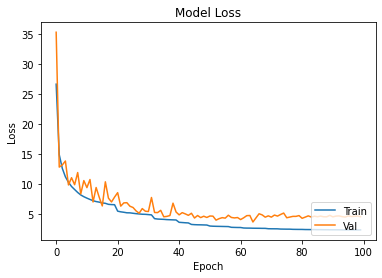

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()
